In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
from pathlib import Path
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
dir_path = Path('/content/drive/MyDrive/food_dataset')

image_list = list(dir_path.glob('*/*/*/*.jpg'))

len(image_list)

953

height: 525 || width: 730
tandoori chicken


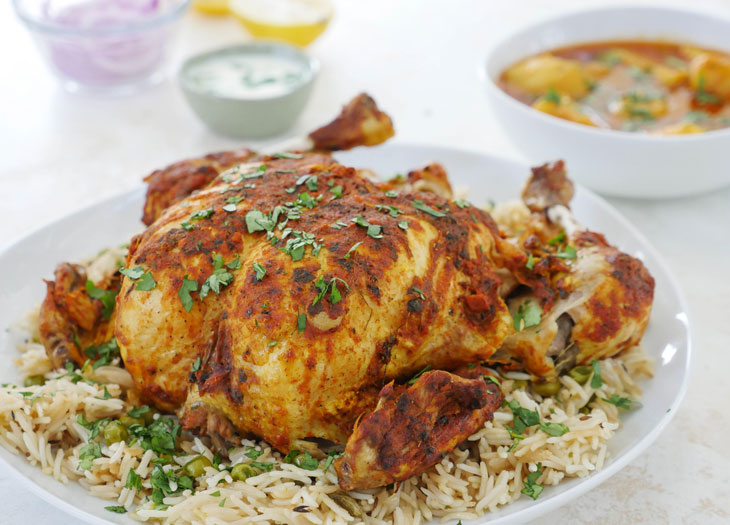

In [ ]:
path = random.choice(image_list)
img = Image.open(path)
print(f"height: {img.height} || width: {img.width}")
print(path.parent.stem)
img

In [ ]:
def plot_image(L=image_list):
    img = random.choice(L)
    pil_image = Image.open(img)
    np_image = np.array(pil_image)
    plt.figure(figsize=(8,8))
    plt.imshow(np_image)
    plt.title(img.parent.stem)
    plt.axis(False)
    plt.show()

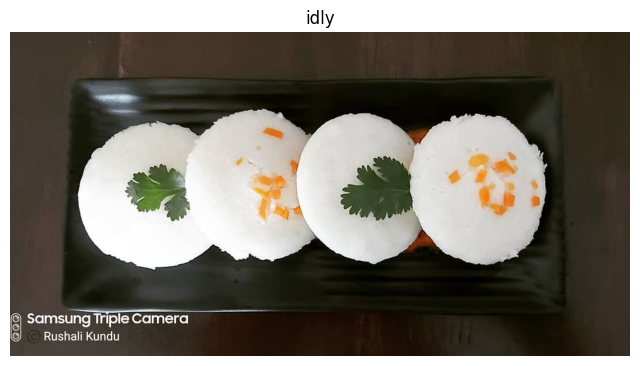

In [ ]:
plot_image()

In [ ]:
train_transforms = T.Compose([
    T.Resize(size=(64,64)),
    T.RandomHorizontalFlip(0.3),
    T.RandomVerticalFlip(0.3),
    T.RandomRotation(degrees=30),
    T.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    T.ToTensor()
])
test_transforms = T.Compose([
    T.Resize(size=(64,64)),
    T.ToTensor()
])

In [ ]:
def plot_difference(L=image_list):

    img = random.choice(image_list)
    pil_image = Image.open(img)
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(np.array(pil_image))
    ax[0].set_title(f'Before: {img.parent.stem}')
    ax[0].axis(False)

    transformed = train_transforms(pil_image)

    ax[1].imshow(transformed.permute(1,2,0))
    ax[1].set_title(f'after: {img.parent.stem}')
    ax[1].axis(False)


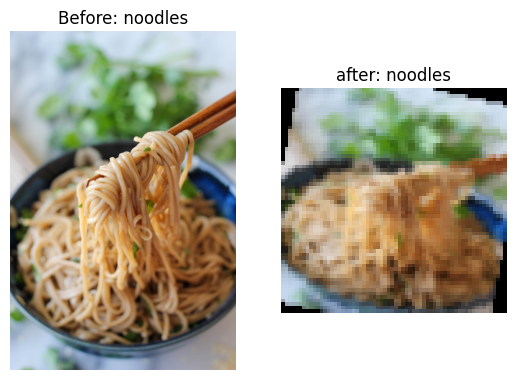

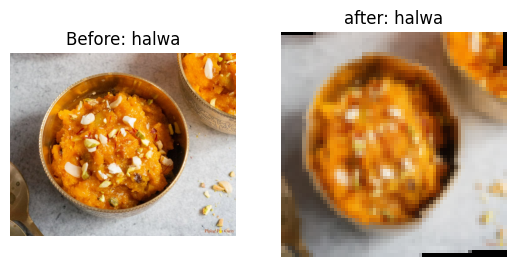

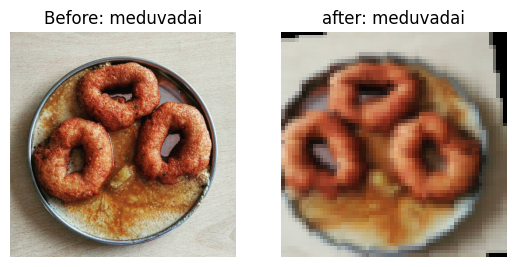

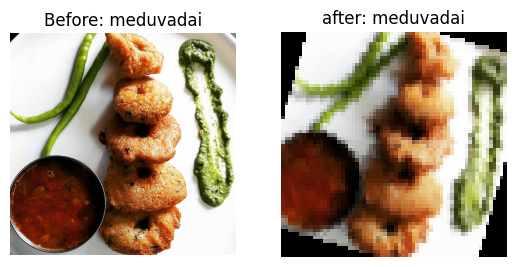

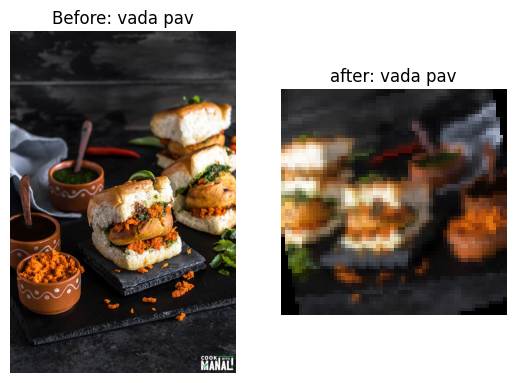

In [ ]:
for i in range(5):
    plot_difference()

In [ ]:
train_dir = dir_path / 'food20dataset/train_set'
test_dir = dir_path / 'food20dataset/test_set'

In [ ]:
all_items = os.listdir('/content/drive/MyDrive/food_dataset/food20dataset/train_set')
labels = {all_items[i]:i for i in range(len(all_items))}
print(labels)

{'vada pav': 0, 'noodles': 1, 'tandoori chicken': 2, 'idly': 3, 'meduvadai': 4, 'samosa': 5, 'kathi roll': 6, 'halwa': 7, 'biriyani': 8, 'gulab jamun': 9, 'dosa': 10}


In [ ]:
class FitFuelDataset(Dataset):
    def __init__(self,dir,transform,labels=labels):
        self.dir = list(dir.glob('*/*.jpg'))
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.dir)

    def __getitem__(self,index):

        path = self.dir[index]
        image = Image.open(path)
        label = self.labels[path.parent.stem]

        return self.transform(image),label


In [ ]:
train_data = FitFuelDataset(dir=train_dir,transform=train_transforms)
test_data = FitFuelDataset(dir=test_dir,transform=test_transforms)
len(train_data),len(test_data)
print(train_data[200])

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 3)


In [ ]:
bs = 1

train_loader = DataLoader(train_data,batch_size=bs,shuffle=True)
test_loader = DataLoader(test_data,batch_size=bs,shuffle=False)

In [ ]:
class FitFuelModel(nn.Module):
    def __init__(self,input_size=3,output_size=len(labels)):
        super().__init__()
        self.conv_blk1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,out_channels=32,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=53824,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16,out_features=output_size)
        )

    def forward(self,x):
        x = self.conv_blk1(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [ ]:
model = FitFuelModel().to(device)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model,input_size=[4,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
FitFuelModel                             [4, 11]                   --
├─Sequential: 1-1                        [4, 16, 58, 58]           --
│    └─Conv2d: 2-1                       [4, 32, 62, 62]           896
│    └─ReLU: 2-2                         [4, 32, 62, 62]           --
│    └─Conv2d: 2-3                       [4, 16, 60, 60]           4,624
│    └─ReLU: 2-4                         [4, 16, 60, 60]           --
│    └─MaxPool2d: 2-5                    [4, 16, 58, 58]           --
├─Sequential: 1-2                        [4, 11]                   --
│    └─Linear: 2-6                       [4, 32]                   1,722,400
│    └─ReLU: 2-7                         [4, 32]                   --
│    └─Linear: 2-8                       [4, 16]                   528
│    └─ReLU: 2-9                         [4, 16]                   --
│    └─Linear: 2-10                      [4, 11]                   187
To

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001,weight_decay=0.00001)

In [ ]:
model.load_state_dict(torch.load('/content/prototype(beta_ 0).pth'))

<All keys matched successfully>

In [ ]:
train_loss_list,test_loss_list = [],[]
epochs = 100

In [ ]:
for epoch in range(epochs):
    total_train_loss,total_test_loss = 0,0

    for batch in train_loader:
        model.train()
        optimizer.zero_grad()
        X,y = batch
        X,y = X.to(device),y.to(device)
        output = model(X)
        train_loss = loss_fn(output,y)
        train_loss.backward()
        optimizer.step()
        total_train_loss += train_loss.item()
    total_train_loss /= len(train_loader)
    train_loss_list.append(total_train_loss)

    for test_batch in test_loader:
        model.eval()
        input,target = test_batch
        input,target = input.to(device),target.to(device)
        output = model(input)
        test_loss = loss_fn(output,target)
        total_test_loss += test_loss.item()
    total_test_loss /= len(test_loader)
    test_loss_list.append(total_test_loss)
    print(f'epoch: {epoch} || test_loss: {total_test_loss} || train_loss: {total_train_loss}')
    if total_test_loss < 1.67:
      break

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(),'prototype(beta: 0).pth')

In [ ]:
img,label = next(iter(test_loader))
ypred = model(img.to(device))
ypred = torch.argmax(ypred,dim=1)
ypred,label

(tensor([2], device='cuda:0'), tensor([2]))

In [ ]:
y_preds =  []
actual = []

model.eval()
with torch.no_grad():
  for X,y in test_loader:
    X,y = X.to(device),y.to(device)
    y_logit = model(X)
    y_pred = torch.argmax(y_logit,dim=1)
    y_preds.append(y_pred)
    actual.append(y)


y_pred_tensor = torch.cat(y_preds)
actual = torch.cat(actual)
y_pred_tensor

KeyboardInterrupt: ignored

In [ ]:
actual

In [ ]:
labels

In [ ]:
img = Image.open('/content/gulab.jpg')
transformed = test_transforms(img).unsqueeze(dim=0)
with torch.inference_mode():
  pred = model(transformed.to(device))
  pred_class = torch.argmax(pred,dim=1)

print(pred_class)


tensor([9], device='cuda:0')


In [ ]:
y_axis = np.array(test_loss_list)
x = np.arange(0,len(test_loss_list))
y_axis = y_axis[:-30]
x = x[:-30]
plt.plot(x,y_axis)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('epoch vs test-loss')
plt.savefig('test.png')
plt.show()

In [ ]:
count = 0
for i in range(len(actual)):
  if actual[i] == y_pred_tensor[i]:
    count += 1

print(count)
print(len(actual))
print(f'Accuracy: {(count / len(actual)) * 100}%')

In [ ]:
cm = confusion_matrix(actual.cpu(),y_pred_tensor.cpu())

In [ ]:
cm

In [ ]:
# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
            xticklabels=range(len(labels)), yticklabels=range(len(labels)))

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.savefig('confusion.png')

# Display the plot
plt.show()


In [ ]:
labels

In [ ]:
clf = classification_report(actual.cpu(),y_pred_tensor.cpu())

In [ ]:
print(clf)